# 1) IMPORTING LIBRARIES AND PACKAGES

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import pickle
from sklearn import model_selection
import matplotlib.pyplot as plt
import model_utils
from geopy.geocoders import Nominatim, GeoNames
from geopy.extra.rate_limiter import RateLimiter
from geopy.distance import great_circle
import lightgbm as lgb

# 2) DATASET IMPORTING

In [3]:
data = pd.read_csv('Data/DataCoSupplyChainDataset.csv',header= 0,encoding='unicode_escape')
pd.set_option('display.max_columns',None)
data.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


# 3) FEATURE ENGINEERING

Convert dates

In [4]:
#Converting categorical features that represent date and time to datetime datatype.
data['order_date'] = pd.to_datetime(data['order date (DateOrders)'])
# Handling Time and date variables
data['order_year'] = pd.DatetimeIndex(data['order_date']).year
data['order_month'] = pd.DatetimeIndex(data['order_date']).month
data['order_day'] = pd.DatetimeIndex(data['order_date']).day

Is it imbalanced?

In [5]:
# Check percentage late_delivery_risk vs non_late_delivery_risk
late_delivery_risk = data['Late_delivery_risk'].value_counts()
print(late_delivery_risk)
print('Percentage of Late Delivery Risk :',round(late_delivery_risk[1]/data.shape[0]*100,2))
perc_late_delivery_risk = round(late_delivery_risk[1]/data.shape[0]*100,2)

Late_delivery_risk
1    98977
0    81542
Name: count, dtype: int64
Percentage of Late Delivery Risk : 54.83


Calculate distances

In [6]:
# Open city coordinates from a file
with open('Data/city_coordinates.pkl', 'rb') as f:
    city_coordinates = pickle.load(f)
city_coordinates = pd.DataFrame(city_coordinates.items(), columns=['Order City', 'Coordinates'])

country_coordinates = pd.read_csv('Data/country_coordinates.csv')

In [7]:
data = pd.merge(data, city_coordinates, on='Order City', how='left')
# Fill in missing city coordinates
data['Coordinates'] = data['Coordinates'].fillna(data['Order Country'].map(country_coordinates.set_index('Order Country')['Coordinates']))
# Fill in values that are not two numbers (latitude, longitude) with (0, 0) (also replace (None, None) with (0, 0))
data['Coordinates'] = data['Coordinates'].apply(lambda x: (0, 0) if not isinstance(x, tuple) or len(x) != 2 else x)
# Fill in values that are contain None (for example (None, None)) with (0, 0)
data['Coordinates'] = data['Coordinates'].apply(lambda x: (0, 0) if x[0] is None else x)
# Split the coordinates into latitude and longitude
data[['Order Latitude', 'Order Longitude']] = pd.DataFrame(data['Coordinates'].tolist(), index=data.index)
data.drop(['Coordinates'], axis=1, inplace=True)
# Change name of Latitude and Longitude columns
data.rename(columns={'Latitude':'Customer Latitude', 'Longitude':'Customer Longitude'}, inplace=True)
data

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Customer Latitude,Customer Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode,order_date,order_year,order_month,order_day,Order Latitude,Order Longitude
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.750000,0.29,1,327.750000,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,2/3/2018 22:56,Standard Class,2018-01-31 22:56:00,2018,1,31,-6.234986,106.994544
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.750000,-0.80,1,327.750000,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/18/2018 12:27,Standard Class,2018-01-13 12:27:00,2018,1,13,28.015929,73.317137
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.750000,-0.80,1,327.750000,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/17/2018 12:06,Standard Class,2018-01-13 12:06:00,2018,1,13,28.015929,73.317137
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.750000,0.08,1,327.750000,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/16/2018 11:45,Standard Class,2018-01-13 11:45:00,2018,1,13,-19.256939,146.823954
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.750000,0.45,1,327.750000,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/15/2018 11:24,Standard Class,2018-01-13 11:24:00,2018,1,13,-19.256939,146.823954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180514,CASH,4,4,40.000000,399.980011,Shipping on time,0,45,Fishing,Brooklyn,EE. UU.,XXXXXXXXX,Maria,1005,Peterson,XXXXX

In [8]:
def calculate_distance(row):
    customer_coords = (row['Customer Latitude'], row['Customer Longitude'])
    order_coords = (row['Order Latitude'], row['Order Longitude'])
    return great_circle(customer_coords, order_coords).kilometers
# Calculate the distance between the customer and the order
data['Distance (km)'] = data.apply(calculate_distance, axis=1)
# Calculate the distance between the customer and the order
data['Distance (km)'] = data.apply(calculate_distance, axis=1)
data

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Customer Latitude,Customer Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode,order_date,order_year,order_month,order_day,Order Latitude,Order Longitude,Distance (km)
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.750000,0.29,1,327.750000,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,2/3/2018 22:56,Standard Class,2018-01-31 22:56:00,2018,1,31,-6.234986,106.994544,18480.084962
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.750000,-0.80,1,327.750000,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/18/2018 12:27,Standard Class,2018-01-13 12:27:00,2018,1,13,28.015929,73.317137,13260.655956
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.750000,-0.80,1,327.750000,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/17/2018 12:06,Standard Class,2018-01-13 12:06:00,2018,1,13,28.015929,73.317137,12581.953241
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.750000,0.08,1,327.750000,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/16/2018 11:45,Standard Class,2018-01-13 11:45:00,2018,1,13,-19.256939,146.823954,11627.746132
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.750000,0.45,1,327.750000,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/15/2018 11:24,Standard Class,2018-01-13 11:24:00,2018,1,13,-19.256939,146.823954,16558.468052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180514,CASH,4,4,40.000000,399.980011

Grab features

In [9]:
print(data.columns)
print(len(data.columns))
unuseful_features = ["Delivery Status","Category Id","Customer City", "Customer Country","Customer Email","Customer Fname","Customer Id","Customer Lname","Customer Password",
                     "Customer State","Customer Street","Customer Zipcode","Department Id","Order City","Order Country","Order Customer Id","Order Item Cardprod Id","Order Item Discount Rate","Order Item Id",
                     "Order Item Profit Ratio","Order Profit Per Order", "Order Region","Order State","Order Zipcode","Product Card Id","Product Category Id","Product Description","Product Image", "Product Price",
                     "Product Status", "shipping date (DateOrders)","order date (DateOrders)", 'order_date']
print(len(unuseful_features))

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Id',
       'Customer Lname', 'Customer Password', 'Customer Segment',
       'Customer State', 'Customer Street', 'Customer Zipcode',
       'Department Id', 'Department Name', 'Customer Latitude',
       'Customer Longitude', 'Market', 'Order City', 'Order Country',
       'Order Customer Id', 'order date (DateOrders)', 'Order Id',
       'Order Item Cardprod Id', 'Order Item Discount',
       'Order Item Discount Rate', 'Order Item Id', 'Order Item Product Price',
       'Order Item Profit Ratio', 'Order Item Quantity', 'Sales',
       'Order Item Total', 'Order Profit Per Order', 'Order Region',
       'Order State', 'Order Status', 'Order Zipcode', 'Product Card Id',
       'Product Categor

In [10]:
useful_features = [col for col in data.columns if col not in unuseful_features]
print(len(useful_features))
print(useful_features)

27
['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)', 'Benefit per order', 'Sales per customer', 'Late_delivery_risk', 'Category Name', 'Customer Segment', 'Department Name', 'Customer Latitude', 'Customer Longitude', 'Market', 'Order Id', 'Order Item Discount', 'Order Item Product Price', 'Order Item Quantity', 'Sales', 'Order Item Total', 'Order Status', 'Product Name', 'Shipping Mode', 'order_year', 'order_month', 'order_day', 'Order Latitude', 'Order Longitude', 'Distance (km)']


In [11]:
new_data = data[useful_features]
statuses_to_drop = ['CANCELED', 'SUSPECTED_FRAUD']
# Drop rows where late delivery risk is always 0 (when the order status is 'CANCELED' or 'SUSPECTED_FRAUD')
model_data = new_data[~new_data['Order Status'].isin(statuses_to_drop)]
# Drop rows where 'Order Status' is in the list of statuses to drop
model_data.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Name,Customer Segment,Department Name,Customer Latitude,Customer Longitude,Market,Order Id,Order Item Discount,Order Item Product Price,Order Item Quantity,Sales,Order Item Total,Order Status,Product Name,Shipping Mode,order_year,order_month,order_day,Order Latitude,Order Longitude,Distance (km)
0,DEBIT,3,4,91.250000,314.640015,0,Sporting Goods,Consumer,Fitness,18.251453,-66.037056,Pacific Asia,77202,13.110000,327.75,1,327.75,314.640015,COMPLETE,Smart watch,Standard Class,2018,1,31,-6.234986,106.994544,18480.084962
1,TRANSFER,5,4,-249.089996,311.359985,1,Sporting Goods,Consumer,Fitness,18.279451,-66.037064,Pacific Asia,75939,16.389999,327.75,1,327.75,311.359985,PENDING,Smart watch,Standard Class,2018,1,13,28.015929,73.317137,13260.655956
2,CASH,4,4,-247.779999,309.720001,0,Sporting Goods,Consumer,Fitness,37.292233,-121.881279,Pacific Asia,75938,18.030001,327.75,1,327.75,309.720001,CLOSED,Smart watch,Standard Class,2018,1,13,28.015929,73.317137,12581.953241
3,DEBIT,3,4,22.860001,304.809998,0,Sporting Goods,Home Office,Fitness,34.125946,-118.291016,Pacific Asia,75937,22.940001,327.75,1,327.75,304.809998,COMPLETE,Smart watch,Standard Class,2018,1,13,-19.256939,146.823954,11627.746132
4,PAYMENT,2,4,134.210007,298.250000,0,Sporting Goods,Corporate,Fitness,18.253769,-66.037048,Pacific Asia,75936,29.500000,327.75,1,327.75,298.250000,PENDING_PAYMENT,Smart watch,Standard Class,2018,1,13,-19.256939,146.823954,16558.468052


In [12]:
#One-Hot encoding categotical variables in the data
model_data = pd.get_dummies(model_data)
model_data.shape
model_data

,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Customer Latitude,Customer Longitude,Order Id,Order Item Discount,Order Item Product Price,Order Item Quantity,Sales,Order Item Total,order_year,order_month,order_day,Order Latitude,Order Longitude,Distance (km),Type_CASH,Type_DEBIT,Type_PAYMENT,Type_TRANSFER,Category Name_Accessories,Category Name_As Seen on TV!,Category Name_Baby,Category Name_Baseball & Softball,Category Name_Basketball,Category Name_Books,Category Name_Boxing & MMA,Category Name_CDs,Category Name_Cameras,Category Name_Camping & Hiking,Category Name_Cardio Equipment,Category Name_Children's Clothing,Category Name_Cleats,Category Name_Computers,Category Name_Consumer Electronics,Category Name_Crafts,Category Name_DVDs,Category Name_Electronics,Category Name_Fishing,Category Name_Fitness Accessories,Category Name_Garden,Category Name_Girls' Apparel,Category Name_Golf Apparel,Category Name_Golf Bags & Carts,Category Name_Golf Balls,Category Name_Golf Gloves,Category Name_Golf Shoes,Category Name_Health and Beauty,Category Name_Hockey,Category Name_Hunting & Shooting,Category Name_Indoor/Outdoor Games,Category Name_Kids' Golf Clubs,Category Name_Lacrosse,Category Name_Men's Clothing,Category Name_Men's Footwear,Category Name_Men's Golf Clubs,Category Name_Music,Category Name_Pet Supplies,Category Name_Shop By Sport,Category Name_Soccer,Category Name_Sporting Goods,Category Name_Strength Training,Category Name_Tennis & Racquet,Category Name_Toys,Category Name_Trade-In,Category Name_Video Games,Category Name_Water Sports,Category Name_Women's Apparel,Category Name_Women's Clothing,Category Name_Women's Golf Clubs,Customer Segment_Consumer,Customer Segment_Corporate,Customer Segment_Home Office,Department Name_Apparel,Department Name_Book Shop,Department Name_Discs Shop,Department Name_Fan Shop,Department Name_Fitness,Department Name_Footwear,Department Name_Golf,Department Name_Health and Beauty,Department Name_Outdoors,Department Name_Pet Shop,Department Name_Technology,Market_Africa,Market_Europe,Market_LATAM,Market_Pacific Asia,Market_USCA,Order Status_CLOSED,Order Status_COMPLETE,Order Status_ON_HOLD,Order Status_PAYMENT_REVIEW,Order Status_PENDING,Order Status_PENDING_PAYMENT,Order Status_PROCESSING,Product Name_Adult dog supplies,Product Name_Baby sweater,Product Name_Bag Boy Beverage Holder,Product Name_Bag Boy M330 Push Cart,Product Name_Bowflex SelectTech 1090 Dumbbells,Product Name_Bridgestone e6 Straight Distance NFL Carolina,Product Name_Bridgestone e6 Straight Distance NFL San Dieg,Product Name_Bridgestone e6 Straight Distance NFL Tennesse,Product Name_Brooks Women's Ghost 6 Running Shoe,Product Name_Bushnell Pro X7 Jolt Slope Rangefinder,Product Name_CDs of rock,Product Name_Children's heaters,Product Name_Cleveland Golf Collegiate My Custom Wedge 588,Product Name_Cleveland Golf Women's 588 RTX CB Satin Chrom,Product Name_Clicgear 8.0 Shoe Brush,Product Name_Clicgear Rovic Cooler Bag,Product Name_Columbia Men's PFG Anchor Tough T-Shirt,Product Name_DVDs,Product Name_Dell Laptop,Product Name_Diamondback Boys' Insight 24 Performance Hybr,Product Name_Diamondback Girls' Clarity 24 Hybrid Bike 201,Product Name_Diamondback Women's Serene Classic Comfort Bi,Product Name_ENO Atlas Hammock Straps,Product Name_Elevation Training Mask 2.0,Product Name_Field & Stream Sportsman 16 Gun Fire Safe,Product Name_Fighting video games,Product Name_First aid kit,Product Name_Fitbit The One Wireless Activity & Sleep Trac,Product Name_Garmin Approach S3 Golf GPS Watch,Product Name_Garmin Approach S4 Golf GPS Watch,Product Name_Garmin Forerunner 910XT GPS Watch,Product Name_Glove It Imperial Golf Towel,Product Name_Glove It Urban Brick Golf Towel,Product Name_Glove It Women's Imperial Golf Glove,Product Name_Glove It Women's Mod Oval 3-Zip Carry All Gol,Product Name_Glove It Women's Mod Oval Golf Glove,Product Name_GoPro HERO3+ Black Edition Camera,Product Name_

In [13]:
num_item_columns = ["Order Item Discount", "Order Item Product Price",
                        "Sales", 'Order Item Total', 'Benefit per order', 'Sales per customer']

cat_item_columns = ["Department Name", "Category Name"]

static_columns = [col for col in model_data.columns if col not in num_item_columns + cat_item_columns + ["Order Id"]]

In [14]:
product_columns = [col for col in model_data.columns if col.startswith('Product Name_')]
# Multiply product dummies with 'Order Item Quantity' to get the quantity per product
product_quantities = model_data[product_columns].multiply(model_data['Order Item Quantity'], axis=0)
# Rename the columns from 'Product Name_X' to 'Product Quantity_X'
product_quantities.columns = [col.replace('Product Name', 'Product Quantity') for col in product_columns]
# Sum the quantities across all items for each order
product_quantities_agg = product_quantities.groupby(model_data['Order Id']).sum()

# Step 2: Sum numeric columns
# Assuming you know which columns are numeric and specific to each order item
# Exclude 'Order Item Quantity' as it's already handled in the first step
numeric_agg = model_data.groupby('Order Id')[num_item_columns].sum()

# Step 3: Aggregate Categorical Columns
# Filter columns related to categorical dummies
categorical_columns = []
for col in cat_item_columns:
    categorical_columns.extend([col for col in model_data.columns if col.startswith(col+'_')])
# Aggregate categorical columns with a max, so that any 1 in the order is retained
categorical_agg = model_data.groupby('Order Id')[categorical_columns].max()

# Combine all aggregated dataframes
agg_df = pd.concat([product_quantities_agg, numeric_agg, categorical_agg], axis=1)

# Now, keep columns that are the same for each order and join with aggregated data
# Assuming the columns 'order_date', 'customer_id', etc., are the same across order items
static_data = model_data.groupby('Order Id').first()[static_columns]

# Combine the static data with the aggregated data
prep_data = pd.concat([static_data, agg_df], axis=1)
# Delete 'Order Item Quantity', and columns starting with 'Product Name' and cat_item_columns
prep_data.drop(columns=['Order Item Quantity'] + product_columns + categorical_columns, inplace=True)
# Change the name of num_item_columns to be more descriptive
prep_data.rename(columns={'Order Item Discount': 'Total Order Item Discount',
                            'Order Item Product Price': 'Total Order Item Product Price',
                            'Sales': 'Total Sales', 'Order Item Total': 'Total Order Item Total',
                            'Benefit per order': 'Total Benefit per Order',
                            'Sales per customer': 'Total Sales per Customer'}, inplace=True)
prep_data

,Days for shipping (real),Days for shipment (scheduled),Late_delivery_risk,Customer Latitude,Customer Longitude,order_year,order_month,order_day,Order Latitude,Order Longitude,Distance (km),Type_CASH,Type_DEBIT,Type_PAYMENT,Type_TRANSFER,Category Name_Accessories,Category Name_As Seen on TV!,Category Name_Baby,Category Name_Baseball & Softball,Category Name_Basketball,Category Name_Books,Category Name_Boxing & MMA,Category Name_CDs,Category Name_Cameras,Category Name_Camping & Hiking,Category Name_Cardio Equipment,Category Name_Children's Clothing,Category Name_Cleats,Category Name_Computers,Category Name_Consumer Electronics,Category Name_Crafts,Category Name_DVDs,Category Name_Electronics,Category Name_Fishing,Category Name_Fitness Accessories,Category Name_Garden,Category Name_Girls' Apparel,Category Name_Golf Apparel,Category Name_Golf Bags & Carts,Category Name_Golf Balls,Category Name_Golf Gloves,Category Name_Golf Shoes,Category Name_Health and Beauty,Category Name_Hockey,Category Name_Hunting & Shooting,Category Name_Indoor/Outdoor Games,Category Name_Kids' Golf Clubs,Category Name_Lacrosse,Category Name_Men's Clothing,Category Name_Men's Footwear,Category Name_Men's Golf Clubs,Category Name_Music,Category Name_Pet Supplies,Category Name_Shop By Sport,Category Name_Soccer,Category Name_Sporting Goods,Category Name_Strength Training,Category Name_Tennis & Racquet,Category Name_Toys,Category Name_Trade-In,Category Name_Video Games,Category Name_Water Sports,Category Name_Women's Apparel,Category Name_Women's Clothing,Category Name_Women's Golf Clubs,Customer Segment_Consumer,Customer Segment_Corporate,Customer Segment_Home Office,Department Name_Apparel,Department Name_Book Shop,Department Name_Discs Shop,Department Name_Fan Shop,Department Name_Fitness,Department Name_Footwear,Department Name_Golf,Department Name_Health and Beauty,Department Name_Outdoors,Department Name_Pet Shop,Department Name_Technology,Market_Africa,Market_Europe,Market_LATAM,Market_Pacific Asia,Market_USCA,Order Status_CLOSED,Order Status_COMPLETE,Order Status_ON_HOLD,Order Status_PAYMENT_REVIEW,Order Status_PENDING,Order Status_PENDING_PAYMENT,Order Status_PROCESSING,Shipping Mode_First Class,Shipping Mode_Same Day,Shipping Mode_Second Class,Shipping Mode_Standard Class,Product Quantity_Adult dog supplies,Product Quantity_Baby sweater,Product Quantity_Bag Boy Beverage Holder,Product Quantity_Bag Boy M330 Push Cart,Product Quantity_Bowflex SelectTech 1090 Dumbbells,Product Quantity_Bridgestone e6 Straight Distance NFL Carolina,Product Quantity_Bridgestone e6 Straight Distance NFL San Dieg,Product Quantity_Bridgestone e6 Straight Distance NFL Tennesse,Product Quantity_Brooks Women's Ghost 6 Running Shoe,Product Quantity_Bushnell Pro X7 Jolt Slope Rangefinder,Product Quantity_CDs of rock,Product Quantity_Children's heaters,Product Quantity_Cleveland Golf Collegiate My Custom Wedge 588,Product Quantity_Cleveland Golf Women's 588 RTX CB Satin Chrom,Product Quantity_Clicgear 8.0 Shoe Brush,Product Quantity_Clicgear Rovic Cooler Bag,Product Quantity_Columbia Men's PFG Anchor Tough T-Shirt,Product Quantity_DVDs,Product Quantity_Dell Laptop,Product Quantity_Diamondback Boys' Insight 24 Performance Hybr,Product Quantity_Diamondback Girls' Clarity 24 Hybrid Bike 201,Product Quantity_Diamondback Women's Serene Classic Comfort Bi,Product Quantity_ENO Atlas Hammock Straps,Product Quantity_Elevation Training Mask 2.0,Product Quantity_Field & Stream Sportsman 16 Gun Fire Safe,Product Quantity_Fighting video games,Product Quantity_First aid kit,Product Quantity_Fitbit The One Wireless Activity & Sleep Trac,Product Quantity_Garmin Approach S3 Golf GPS Watch,Product Quantity_Garmin Approach S4 Golf GPS Watch,Product Quantity_Garmin Forerunner 910XT GPS Watch,Product Quantity_Glove It Imperial Golf Towel,Product Quantity_Glove It Urban Brick Golf Towel,Product Quantity_Glove It Women's Imperial Golf Glove,Product Quantity_Glove It Women's Mod Oval 3-Zip Carry All Gol

# 4) Classification

In [15]:
x_class = prep_data.drop(['Late_delivery_risk', 'Days for shipping (real)'],axis=1)
y_class = prep_data[['Late_delivery_risk']]
# train-test_split
x_train_class,x_test_class,y_train_class,y_test_class = model_selection.train_test_split(x_class,y_class,test_size=0.20,random_state=42,stratify=y_class)
# train-validation split
x_train_class,x_val_class,y_train_class,y_val_class = model_selection.train_test_split(x_train_class,y_train_class,test_size=0.25,random_state=42,stratify=y_train_class)

In [16]:
grid_params = {
    "batch_size": [64],
    "hidden_layer_sizes": [(64, 32), (128, 64), (128, 64, 32)],
    "learning_rate_init": [0.0001, 0.001, 0.01],
    "activation": ['relu', 'tanh']
}

mlp_classifier_pipeline trained


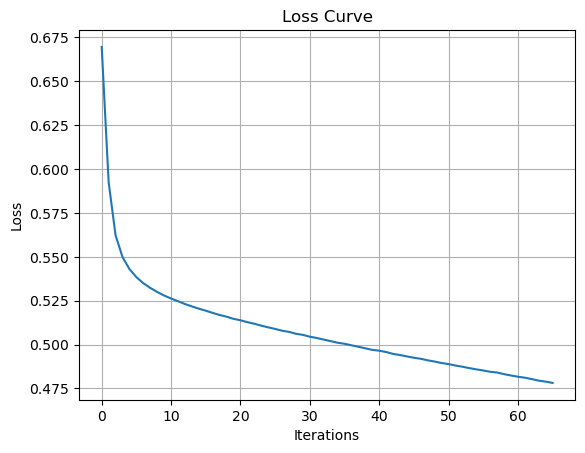

Accuracy for mlp_classifier_pipeline: 0.6851351351351351
ROC for mlp_classifier_pipeline: 0.7034987873763162
Report for mlp_classifier_pipeline:               precision    recall  f1-score   support

           0       0.59      0.83      0.69      5370
           1       0.82      0.58      0.68      7210

    accuracy                           0.69     12580
   macro avg       0.71      0.70      0.68     12580
weighted avg       0.72      0.69      0.68     12580

Combination: (64, (64, 32), 0.0001, 'relu') ROC: {'mlp_classifier_pipeline': 0.7034987873763162}


mlp_classifier_pipeline trained


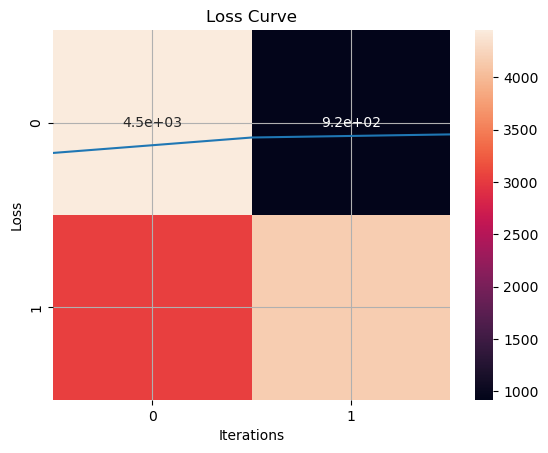

Accuracy for mlp_classifier_pipeline: 0.6773449920508744
ROC for mlp_classifier_pipeline: 0.6922354633668839
Report for mlp_classifier_pipeline:               precision    recall  f1-score   support

           0       0.59      0.79      0.68      5370
           1       0.79      0.59      0.68      7210

    accuracy                           0.68     12580
   macro avg       0.69      0.69      0.68     12580
weighted avg       0.71      0.68      0.68     12580

Combination: (64, (64, 32), 0.0001, 'tanh') ROC: {'mlp_classifier_pipeline': 0.6922354633668839}


mlp_classifier_pipeline trained


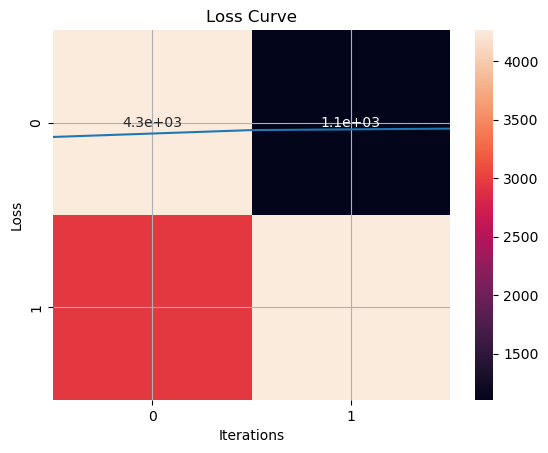

Accuracy for mlp_classifier_pipeline: 0.6858505564387918
ROC for mlp_classifier_pipeline: 0.7036714474258543
Report for mlp_classifier_pipeline:               precision    recall  f1-score   support

           0       0.60      0.83      0.69      5370
           1       0.82      0.58      0.68      7210

    accuracy                           0.69     12580
   macro avg       0.71      0.70      0.69     12580
weighted avg       0.72      0.69      0.68     12580

Combination: (64, (64, 32), 0.001, 'relu') ROC: {'mlp_classifier_pipeline': 0.7036714474258543}


mlp_classifier_pipeline trained


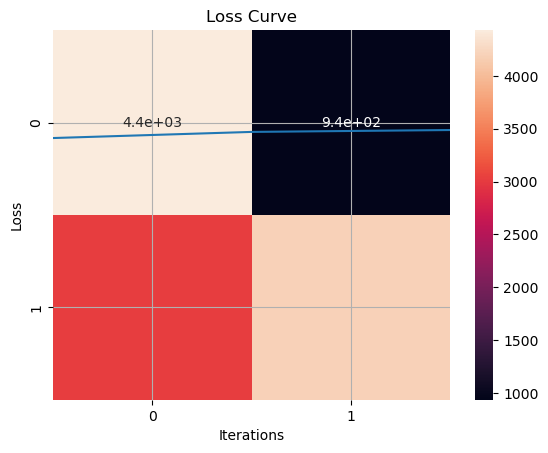

Accuracy for mlp_classifier_pipeline: 0.6753577106518283
ROC for mlp_classifier_pipeline: 0.6883156799086723
Report for mlp_classifier_pipeline:               precision    recall  f1-score   support

           0       0.59      0.78      0.67      5370
           1       0.78      0.60      0.68      7210

    accuracy                           0.68     12580
   macro avg       0.69      0.69      0.68     12580
weighted avg       0.70      0.68      0.68     12580

Combination: (64, (64, 32), 0.001, 'tanh') ROC: {'mlp_classifier_pipeline': 0.6883156799086723}


mlp_classifier_pipeline trained


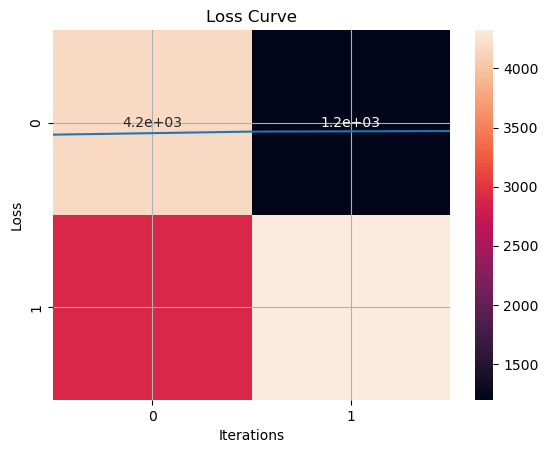

Accuracy for mlp_classifier_pipeline: 0.6887122416534182
ROC for mlp_classifier_pipeline: 0.7115856572058775
Report for mlp_classifier_pipeline:               precision    recall  f1-score   support

           0       0.59      0.87      0.70      5370
           1       0.85      0.56      0.67      7210

    accuracy                           0.69     12580
   macro avg       0.72      0.71      0.69     12580
weighted avg       0.74      0.69      0.69     12580

Combination: (64, (64, 32), 0.01, 'relu') ROC: {'mlp_classifier_pipeline': 0.7115856572058775}


mlp_classifier_pipeline trained


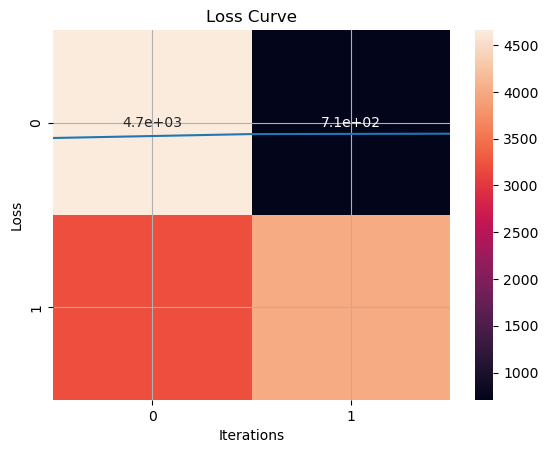

Accuracy for mlp_classifier_pipeline: 0.6848966613672496
ROC for mlp_classifier_pipeline: 0.7069738130105869
Report for mlp_classifier_pipeline:               precision    recall  f1-score   support

           0       0.59      0.86      0.70      5370
           1       0.84      0.56      0.67      7210

    accuracy                           0.68     12580
   macro avg       0.72      0.71      0.68     12580
weighted avg       0.73      0.68      0.68     12580

Combination: (64, (64, 32), 0.01, 'tanh') ROC: {'mlp_classifier_pipeline': 0.7069738130105869}


mlp_classifier_pipeline trained


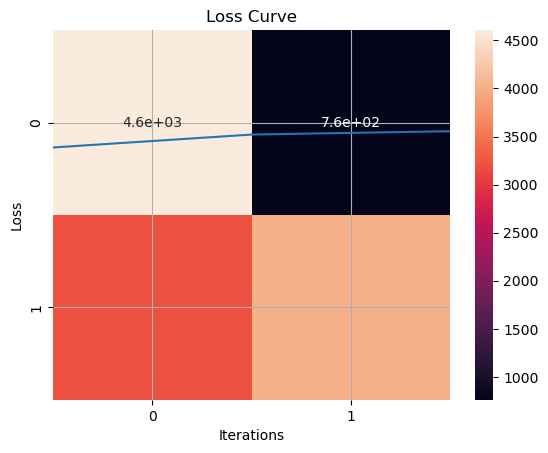

Accuracy for mlp_classifier_pipeline: 0.6866454689984102
ROC for mlp_classifier_pipeline: 0.7041748347654949
Report for mlp_classifier_pipeline:               precision    recall  f1-score   support

           0       0.60      0.82      0.69      5370
           1       0.82      0.58      0.68      7210

    accuracy                           0.69     12580
   macro avg       0.71      0.70      0.69     12580
weighted avg       0.72      0.69      0.69     12580

Combination: (64, (128, 64), 0.0001, 'relu') ROC: {'mlp_classifier_pipeline': 0.7041748347654949}


mlp_classifier_pipeline trained


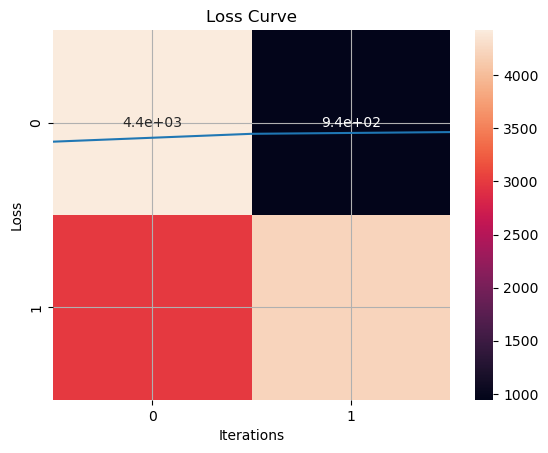

Accuracy for mlp_classifier_pipeline: 0.6790143084260731
ROC for mlp_classifier_pipeline: 0.6955451899260544
Report for mlp_classifier_pipeline:               precision    recall  f1-score   support

           0       0.59      0.81      0.68      5370
           1       0.80      0.58      0.68      7210

    accuracy                           0.68     12580
   macro avg       0.70      0.70      0.68     12580
weighted avg       0.71      0.68      0.68     12580

Combination: (64, (128, 64), 0.0001, 'tanh') ROC: {'mlp_classifier_pipeline': 0.6955451899260544}


mlp_classifier_pipeline trained


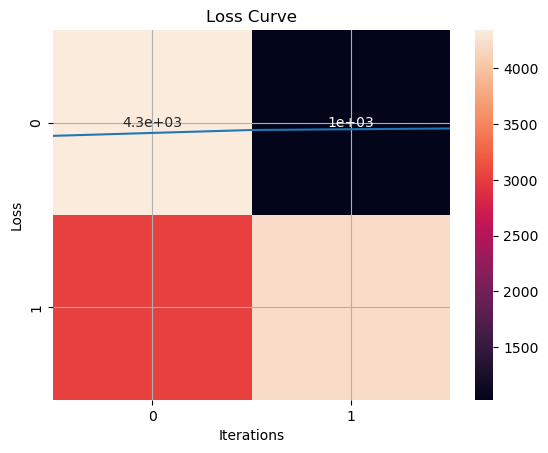

Accuracy for mlp_classifier_pipeline: 0.6847376788553259
ROC for mlp_classifier_pipeline: 0.7044351808087773
Report for mlp_classifier_pipeline:               precision    recall  f1-score   support

           0       0.59      0.84      0.69      5370
           1       0.83      0.57      0.67      7210

    accuracy                           0.68     12580
   macro avg       0.71      0.70      0.68     12580
weighted avg       0.73      0.68      0.68     12580

Combination: (64, (128, 64), 0.001, 'relu') ROC: {'mlp_classifier_pipeline': 0.7044351808087773}


mlp_classifier_pipeline trained


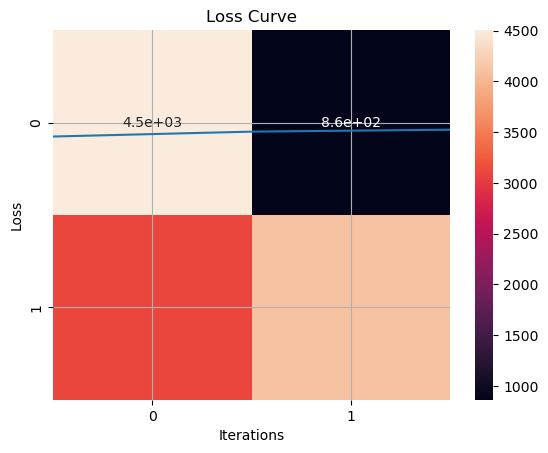

Accuracy for mlp_classifier_pipeline: 0.6726550079491256
ROC for mlp_classifier_pipeline: 0.6841757129168313
Report for mlp_classifier_pipeline:               precision    recall  f1-score   support

           0       0.59      0.76      0.67      5370
           1       0.77      0.61      0.68      7210

    accuracy                           0.67     12580
   macro avg       0.68      0.68      0.67     12580
weighted avg       0.70      0.67      0.67     12580

Combination: (64, (128, 64), 0.001, 'tanh') ROC: {'mlp_classifier_pipeline': 0.6841757129168313}


mlp_classifier_pipeline trained


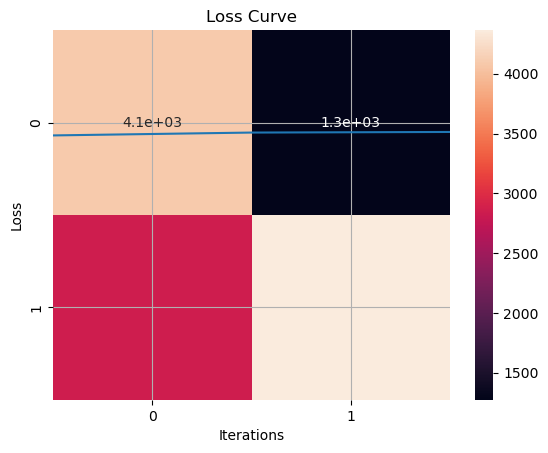

Accuracy for mlp_classifier_pipeline: 0.6893481717011128
ROC for mlp_classifier_pipeline: 0.7131621971346438
Report for mlp_classifier_pipeline:               precision    recall  f1-score   support

           0       0.59      0.88      0.71      5370
           1       0.86      0.55      0.67      7210

    accuracy                           0.69     12580
   macro avg       0.72      0.71      0.69     12580
weighted avg       0.74      0.69      0.69     12580

Combination: (64, (128, 64), 0.01, 'relu') ROC: {'mlp_classifier_pipeline': 0.7131621971346438}


mlp_classifier_pipeline trained


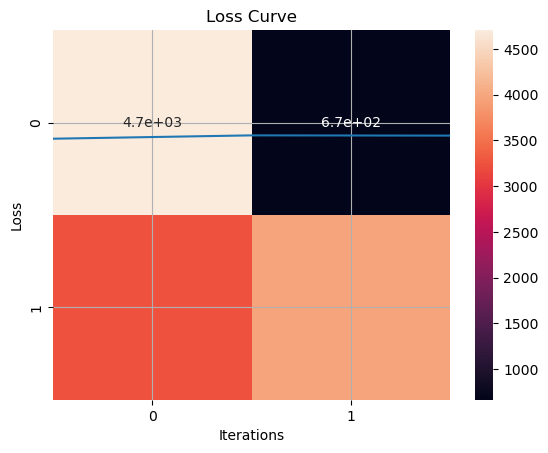

Accuracy for mlp_classifier_pipeline: 0.6879968203497615
ROC for mlp_classifier_pipeline: 0.71162685283475
Report for mlp_classifier_pipeline:               precision    recall  f1-score   support

           0       0.59      0.87      0.70      5370
           1       0.85      0.55      0.67      7210

    accuracy                           0.69     12580
   macro avg       0.72      0.71      0.69     12580
weighted avg       0.74      0.69      0.68     12580

Combination: (64, (128, 64), 0.01, 'tanh') ROC: {'mlp_classifier_pipeline': 0.71162685283475}


mlp_classifier_pipeline trained


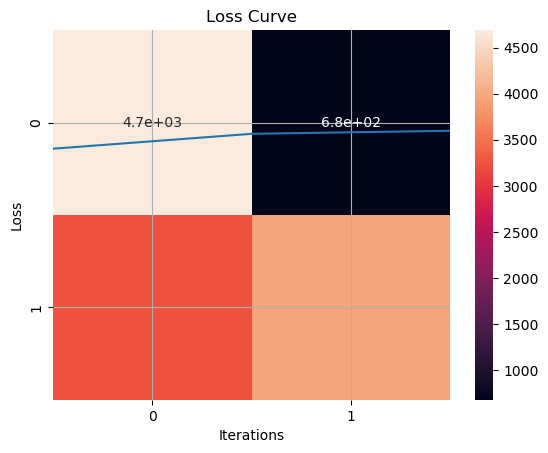

Accuracy for mlp_classifier_pipeline: 0.6844197138314785
ROC for mlp_classifier_pipeline: 0.7045617379131509
Report for mlp_classifier_pipeline:               precision    recall  f1-score   support

           0       0.59      0.84      0.69      5370
           1       0.83      0.57      0.67      7210

    accuracy                           0.68     12580
   macro avg       0.71      0.70      0.68     12580
weighted avg       0.73      0.68      0.68     12580

Combination: (64, (128, 64, 32), 0.0001, 'relu') ROC: {'mlp_classifier_pipeline': 0.7045617379131509}


mlp_classifier_pipeline trained


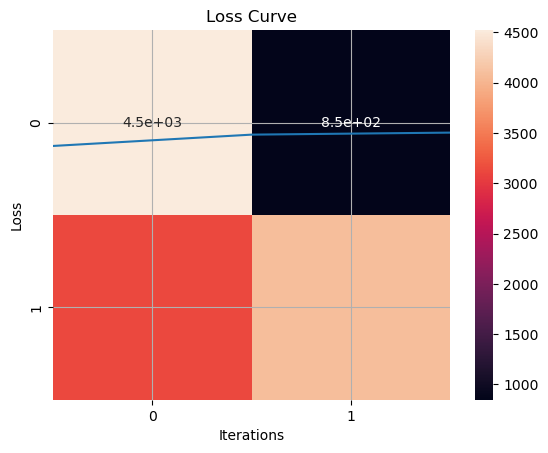

Accuracy for mlp_classifier_pipeline: 0.6735294117647059
ROC for mlp_classifier_pipeline: 0.6870295756204526
Report for mlp_classifier_pipeline:               precision    recall  f1-score   support

           0       0.59      0.78      0.67      5370
           1       0.78      0.59      0.68      7210

    accuracy                           0.67     12580
   macro avg       0.69      0.69      0.67     12580
weighted avg       0.70      0.67      0.67     12580

Combination: (64, (128, 64, 32), 0.0001, 'tanh') ROC: {'mlp_classifier_pipeline': 0.6870295756204526}


mlp_classifier_pipeline trained


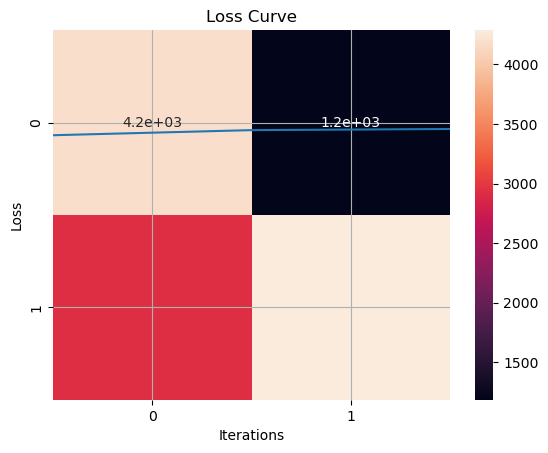

Accuracy for mlp_classifier_pipeline: 0.6860095389507154
ROC for mlp_classifier_pipeline: 0.7096792939663255
Report for mlp_classifier_pipeline:               precision    recall  f1-score   support

           0       0.59      0.87      0.70      5370
           1       0.85      0.55      0.67      7210

    accuracy                           0.69     12580
   macro avg       0.72      0.71      0.68     12580
weighted avg       0.74      0.69      0.68     12580

Combination: (64, (128, 64, 32), 0.001, 'relu') ROC: {'mlp_classifier_pipeline': 0.7096792939663255}


mlp_classifier_pipeline trained


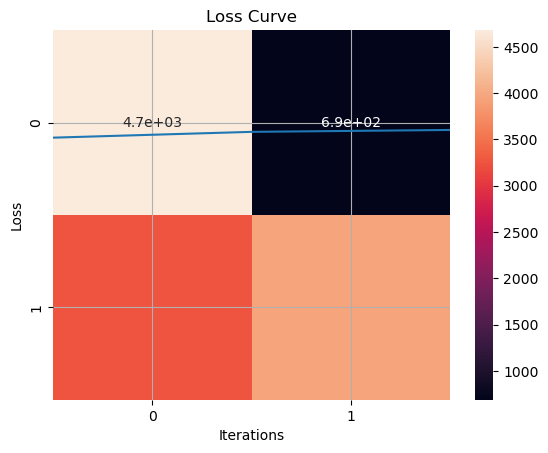

Accuracy for mlp_classifier_pipeline: 0.6797297297297298
ROC for mlp_classifier_pipeline: 0.6950049977142236
Report for mlp_classifier_pipeline:               precision    recall  f1-score   support

           0       0.59      0.80      0.68      5370
           1       0.80      0.59      0.68      7210

    accuracy                           0.68     12580
   macro avg       0.70      0.70      0.68     12580
weighted avg       0.71      0.68      0.68     12580

Combination: (64, (128, 64, 32), 0.001, 'tanh') ROC: {'mlp_classifier_pipeline': 0.6950049977142236}


mlp_classifier_pipeline trained


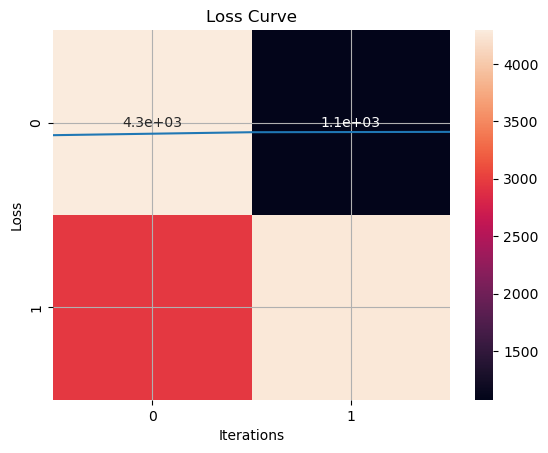

Accuracy for mlp_classifier_pipeline: 0.6883942766295708
ROC for mlp_classifier_pipeline: 0.7129715866386691
Report for mlp_classifier_pipeline:               precision    recall  f1-score   support

           0       0.59      0.88      0.71      5370
           1       0.86      0.54      0.67      7210

    accuracy                           0.69     12580
   macro avg       0.73      0.71      0.69     12580
weighted avg       0.75      0.69      0.68     12580

Combination: (64, (128, 64, 32), 0.01, 'relu') ROC: {'mlp_classifier_pipeline': 0.7129715866386691}


mlp_classifier_pipeline trained


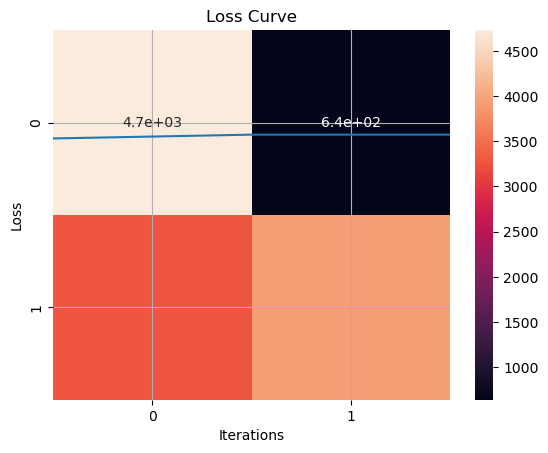

Accuracy for mlp_classifier_pipeline: 0.689268680445151
ROC for mlp_classifier_pipeline: 0.7130928490070433
Report for mlp_classifier_pipeline:               precision    recall  f1-score   support

           0       0.59      0.88      0.71      5370
           1       0.86      0.55      0.67      7210

    accuracy                           0.69     12580
   macro avg       0.72      0.71      0.69     12580
weighted avg       0.74      0.69      0.69     12580

Combination: (64, (128, 64, 32), 0.01, 'tanh') ROC: {'mlp_classifier_pipeline': 0.7130928490070433}




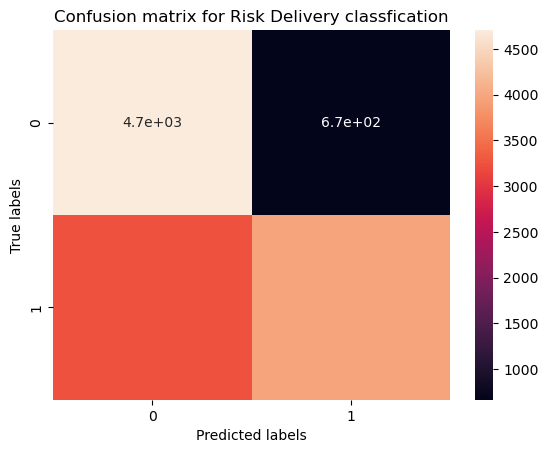

In [17]:
import itertools
# Do a grid search to find the best hyperparameters
keys, values = zip(*grid_params.items())
model_ranking_class = {}
models_class = {}
# Iterate over every combination of parameters
for combination in itertools.product(*values):
    # Create a dictionary for the current combination of parameters
    params = dict(zip(keys, combination))
    # You can now use the 'params' dictionary for training or evaluation
    nn_models = model_utils.init_nn(params,type='classification')
    model_utils.train_models(nn_models, x_train_class, y_train_class)
    preds = model_utils.predict(nn_models, x_test_class)
    acc,roc,rep = model_utils.eval_classification(y_true=y_test_class,preds=preds)
    model_ranking_class[combination] = roc
    models_class[combination] = nn_models
    print('Combination:',combination,'ROC:',roc)
    print('\n')


In [18]:
# Sort the models by their ROC AUC score, from highest to lowest, each item in model_ranking is a dictionary
sorted_models_class = sorted(model_ranking_class.items(), key=lambda x: x[1]["mlp_classifier_pipeline"], reverse=True)
sorted_models_class[:10]

[((64, (128, 64), 0.01, 'relu'),
  {'mlp_classifier_pipeline': 0.7131621971346438}),
 ((64, (128, 64, 32), 0.01, 'tanh'),
  {'mlp_classifier_pipeline': 0.7130928490070433}),
 ((64, (128, 64, 32), 0.01, 'relu'),
  {'mlp_classifier_pipeline': 0.7129715866386691}),
 ((64, (128, 64), 0.01, 'tanh'),
  {'mlp_classifier_pipeline': 0.71162685283475}),
 ((64, (64, 32), 0.01, 'relu'),
  {'mlp_classifier_pipeline': 0.7115856572058775}),
 ((64, (128, 64, 32), 0.001, 'relu'),
  {'mlp_classifier_pipeline': 0.7096792939663255}),
 ((64, (64, 32), 0.01, 'tanh'),
  {'mlp_classifier_pipeline': 0.7069738130105869}),
 ((64, (128, 64, 32), 0.0001, 'relu'),
  {'mlp_classifier_pipeline': 0.7045617379131509}),
 ((64, (128, 64), 0.001, 'relu'),
  {'mlp_classifier_pipeline': 0.7044351808087773}),
 ((64, (128, 64), 0.0001, 'relu'),
  {'mlp_classifier_pipeline': 0.7041748347654949})]

In [22]:
# Save the best model using pickle
best_params_class = sorted_models_class[0][0]
best_model_class = models_class[best_params_class]
with open('best_model_class.pkl', 'wb') as f:
    pickle.dump(best_model_class, f)

# 5) Regression

In [23]:
x_reg = prep_data.drop(['Late_delivery_risk', 'Days for shipping (real)'],axis=1)
y_reg = prep_data[['Days for shipping (real)']]
# train-test_split
x_train_reg,x_test_reg,y_train_reg,y_test_reg = model_selection.train_test_split(x_reg,y_reg,test_size=0.20,random_state=42,stratify=y_reg)
# train-validation split
x_train_reg,x_val_reg,y_train_reg,y_val_reg = model_selection.train_test_split(x_train_reg,y_train_reg,test_size=0.25,random_state=42,stratify=y_train_reg)

In [24]:
grid_params = {
    "batch_size": [64],
    "hidden_layer_sizes": [(64, 32), (128, 64), (128, 64, 32)],
    "learning_rate_init": [0.0001, 0.001, 0.01],
    "activation": ['relu', 'tanh']
}

mlp_regressor_pipeline trained


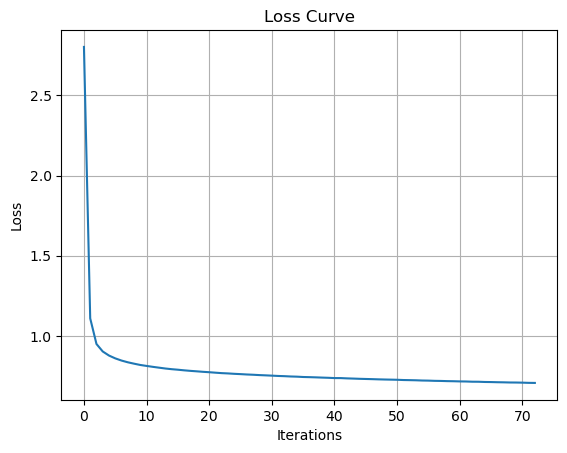

R2 for mlp_regressor_pipeline: 0.3530648746788635
MSE for mlp_regressor_pipeline: 1.705633912782096
MAE for mlp_regressor_pipeline: 1.0519717581919268
Combination: (64, (64, 32), 0.0001, 'relu') , R2: {'mlp_regressor_pipeline': 0.3530648746788635} , MSE: {'mlp_regressor_pipeline': 1.705633912782096} , MAE: {'mlp_regressor_pipeline': 1.0519717581919268}


mlp_regressor_pipeline trained


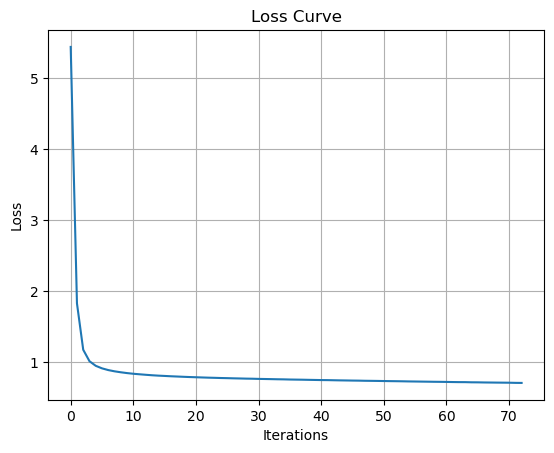

R2 for mlp_regressor_pipeline: 0.3553848160313633
MSE for mlp_regressor_pipeline: 1.6995174252215774
MAE for mlp_regressor_pipeline: 1.050649405472454
Combination: (64, (64, 32), 0.0001, 'tanh') , R2: {'mlp_regressor_pipeline': 0.3553848160313633} , MSE: {'mlp_regressor_pipeline': 1.6995174252215774} , MAE: {'mlp_regressor_pipeline': 1.050649405472454}


mlp_regressor_pipeline trained


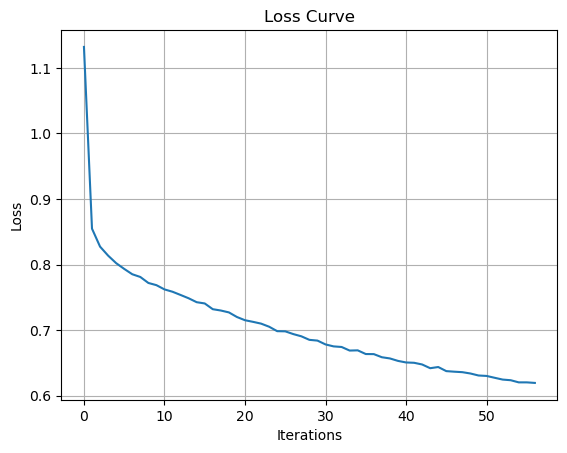

R2 for mlp_regressor_pipeline: 0.347177132996245
MSE for mlp_regressor_pipeline: 1.7211568477573609
MAE for mlp_regressor_pipeline: 1.0544953456480706
Combination: (64, (64, 32), 0.001, 'relu') , R2: {'mlp_regressor_pipeline': 0.347177132996245} , MSE: {'mlp_regressor_pipeline': 1.7211568477573609} , MAE: {'mlp_regressor_pipeline': 1.0544953456480706}


mlp_regressor_pipeline trained


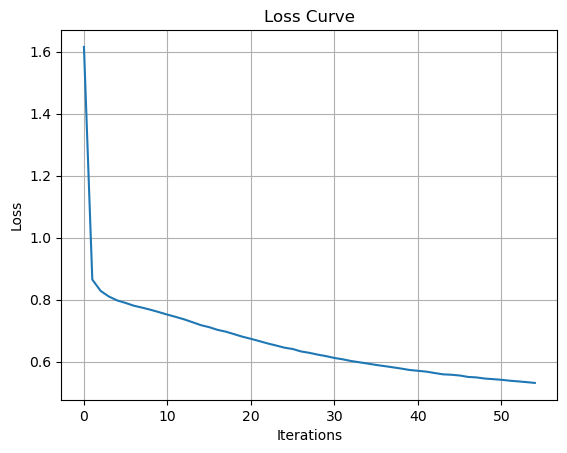

R2 for mlp_regressor_pipeline: 0.3569399296441299
MSE for mlp_regressor_pipeline: 1.6954173935300736
MAE for mlp_regressor_pipeline: 1.0496781486150344
Combination: (64, (64, 32), 0.001, 'tanh') , R2: {'mlp_regressor_pipeline': 0.3569399296441299} , MSE: {'mlp_regressor_pipeline': 1.6954173935300736} , MAE: {'mlp_regressor_pipeline': 1.0496781486150344}


mlp_regressor_pipeline trained


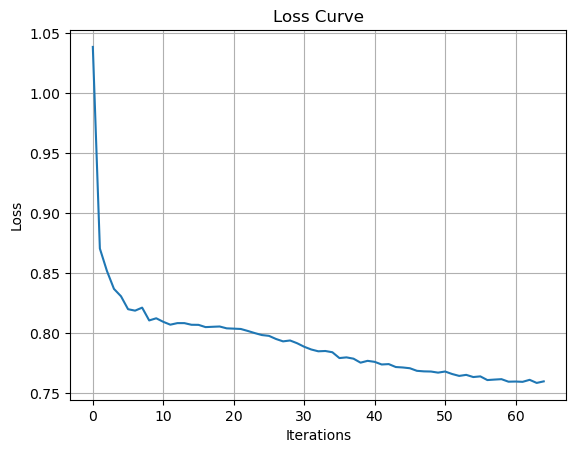

R2 for mlp_regressor_pipeline: 0.38307701687713924
MSE for mlp_regressor_pipeline: 1.6265073890781816
MAE for mlp_regressor_pipeline: 1.0178588589258981
Combination: (64, (64, 32), 0.01, 'relu') , R2: {'mlp_regressor_pipeline': 0.38307701687713924} , MSE: {'mlp_regressor_pipeline': 1.6265073890781816} , MAE: {'mlp_regressor_pipeline': 1.0178588589258981}


mlp_regressor_pipeline trained


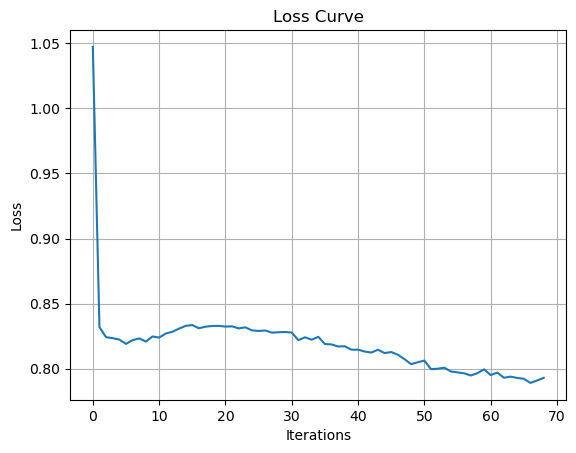

R2 for mlp_regressor_pipeline: 0.38061583034261715
MSE for mlp_regressor_pipeline: 1.6329962672587872
MAE for mlp_regressor_pipeline: 1.0162721813726485
Combination: (64, (64, 32), 0.01, 'tanh') , R2: {'mlp_regressor_pipeline': 0.38061583034261715} , MSE: {'mlp_regressor_pipeline': 1.6329962672587872} , MAE: {'mlp_regressor_pipeline': 1.0162721813726485}


mlp_regressor_pipeline trained


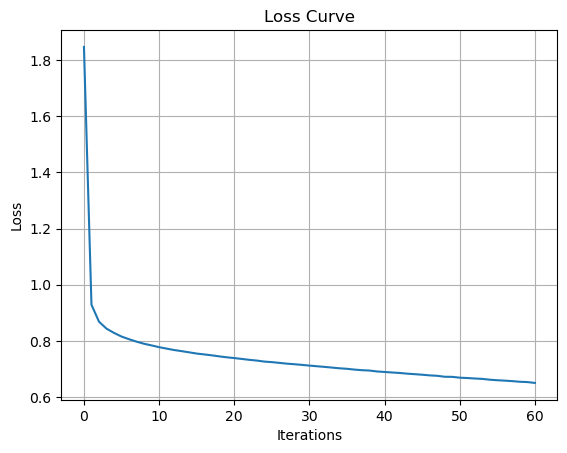

R2 for mlp_regressor_pipeline: 0.3521043019426574
MSE for mlp_regressor_pipeline: 1.7081664471436422
MAE for mlp_regressor_pipeline: 1.0516253678738956
Combination: (64, (128, 64), 0.0001, 'relu') , R2: {'mlp_regressor_pipeline': 0.3521043019426574} , MSE: {'mlp_regressor_pipeline': 1.7081664471436422} , MAE: {'mlp_regressor_pipeline': 1.0516253678738956}


mlp_regressor_pipeline trained


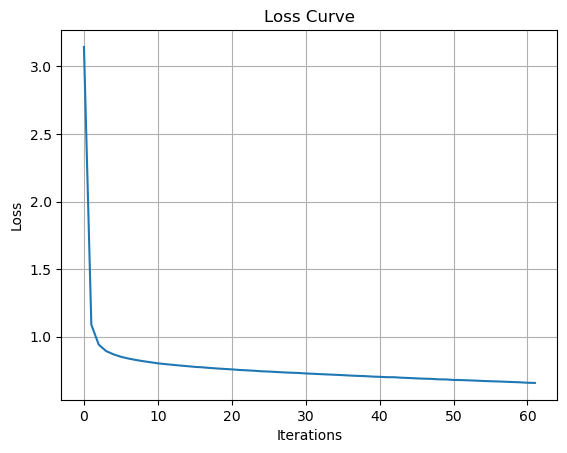

R2 for mlp_regressor_pipeline: 0.3496108271455921
MSE for mlp_regressor_pipeline: 1.71474045280214
MAE for mlp_regressor_pipeline: 1.0594880392652204
Combination: (64, (128, 64), 0.0001, 'tanh') , R2: {'mlp_regressor_pipeline': 0.3496108271455921} , MSE: {'mlp_regressor_pipeline': 1.71474045280214} , MAE: {'mlp_regressor_pipeline': 1.0594880392652204}


mlp_regressor_pipeline trained


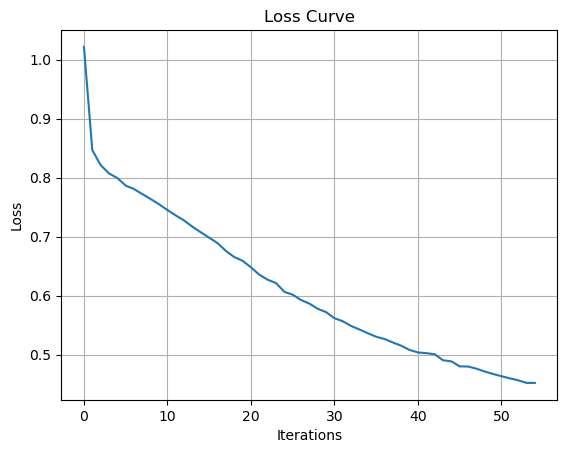

R2 for mlp_regressor_pipeline: 0.34334484799669807
MSE for mlp_regressor_pipeline: 1.7312606046919201
MAE for mlp_regressor_pipeline: 1.0573977449697296
Combination: (64, (128, 64), 0.001, 'relu') , R2: {'mlp_regressor_pipeline': 0.34334484799669807} , MSE: {'mlp_regressor_pipeline': 1.7312606046919201} , MAE: {'mlp_regressor_pipeline': 1.0573977449697296}


mlp_regressor_pipeline trained


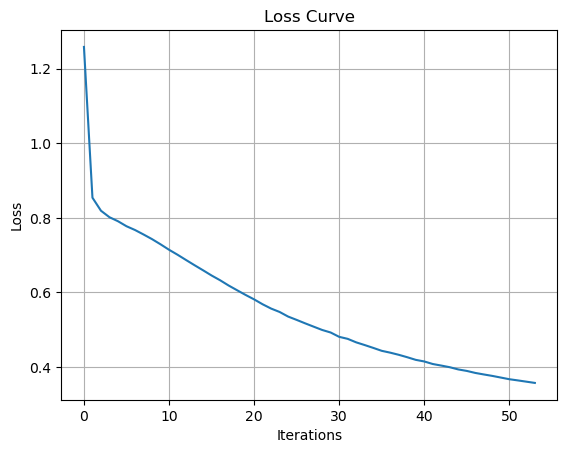

R2 for mlp_regressor_pipeline: 0.3515842800206451
MSE for mlp_regressor_pipeline: 1.7095374764646023
MAE for mlp_regressor_pipeline: 1.059446263249647
Combination: (64, (128, 64), 0.001, 'tanh') , R2: {'mlp_regressor_pipeline': 0.3515842800206451} , MSE: {'mlp_regressor_pipeline': 1.7095374764646023} , MAE: {'mlp_regressor_pipeline': 1.059446263249647}


mlp_regressor_pipeline trained


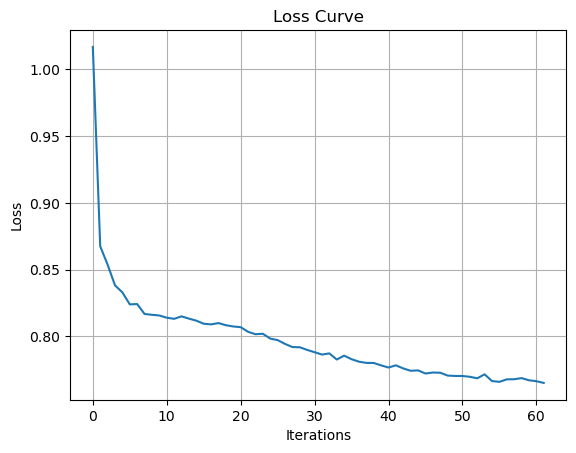

R2 for mlp_regressor_pipeline: 0.38381015881349767
MSE for mlp_regressor_pipeline: 1.624574472313282
MAE for mlp_regressor_pipeline: 1.0215575579129397
Combination: (64, (128, 64), 0.01, 'relu') , R2: {'mlp_regressor_pipeline': 0.38381015881349767} , MSE: {'mlp_regressor_pipeline': 1.624574472313282} , MAE: {'mlp_regressor_pipeline': 1.0215575579129397}


mlp_regressor_pipeline trained


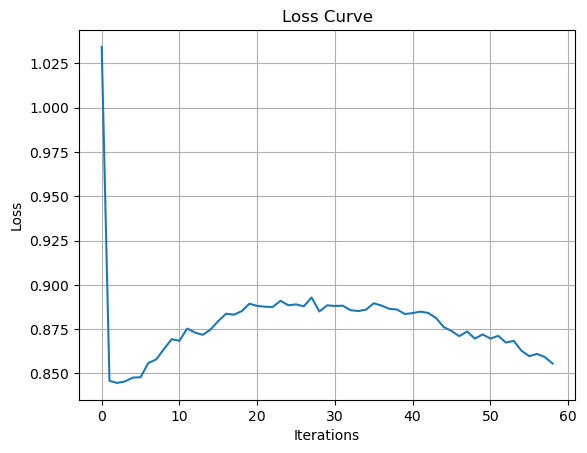

R2 for mlp_regressor_pipeline: 0.36630475510533356
MSE for mlp_regressor_pipeline: 1.6707271838494888
MAE for mlp_regressor_pipeline: 1.0354015968855306
Combination: (64, (128, 64), 0.01, 'tanh') , R2: {'mlp_regressor_pipeline': 0.36630475510533356} , MSE: {'mlp_regressor_pipeline': 1.6707271838494888} , MAE: {'mlp_regressor_pipeline': 1.0354015968855306}


mlp_regressor_pipeline trained


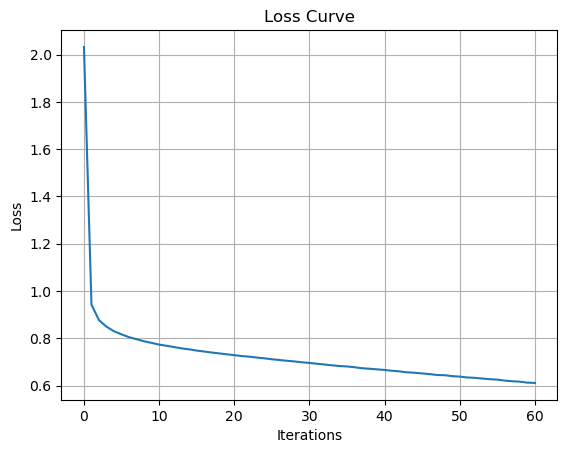

R2 for mlp_regressor_pipeline: 0.34934334483554774
MSE for mlp_regressor_pipeline: 1.7154456655525754
MAE for mlp_regressor_pipeline: 1.0558427669259998
Combination: (64, (128, 64, 32), 0.0001, 'relu') , R2: {'mlp_regressor_pipeline': 0.34934334483554774} , MSE: {'mlp_regressor_pipeline': 1.7154456655525754} , MAE: {'mlp_regressor_pipeline': 1.0558427669259998}


mlp_regressor_pipeline trained


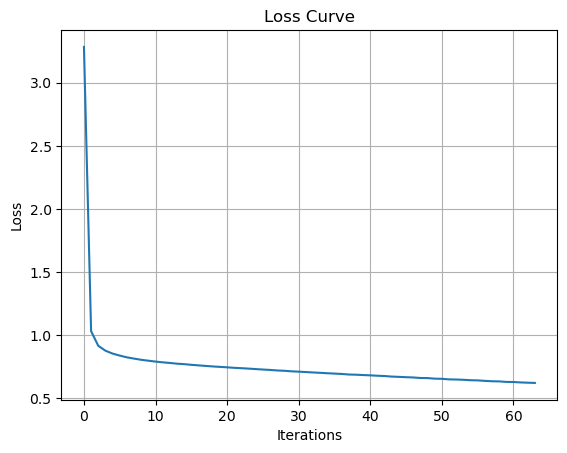

R2 for mlp_regressor_pipeline: 0.3528184855668707
MSE for mlp_regressor_pipeline: 1.7062835136596903
MAE for mlp_regressor_pipeline: 1.0571179327714417
Combination: (64, (128, 64, 32), 0.0001, 'tanh') , R2: {'mlp_regressor_pipeline': 0.3528184855668707} , MSE: {'mlp_regressor_pipeline': 1.7062835136596903} , MAE: {'mlp_regressor_pipeline': 1.0571179327714417}


mlp_regressor_pipeline trained


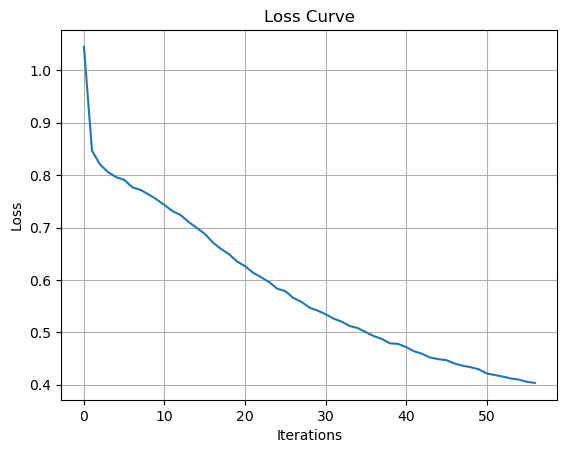

R2 for mlp_regressor_pipeline: 0.3545041838475702
MSE for mlp_regressor_pipeline: 1.7018391976197285
MAE for mlp_regressor_pipeline: 1.045454998759125
Combination: (64, (128, 64, 32), 0.001, 'relu') , R2: {'mlp_regressor_pipeline': 0.3545041838475702} , MSE: {'mlp_regressor_pipeline': 1.7018391976197285} , MAE: {'mlp_regressor_pipeline': 1.045454998759125}


mlp_regressor_pipeline trained


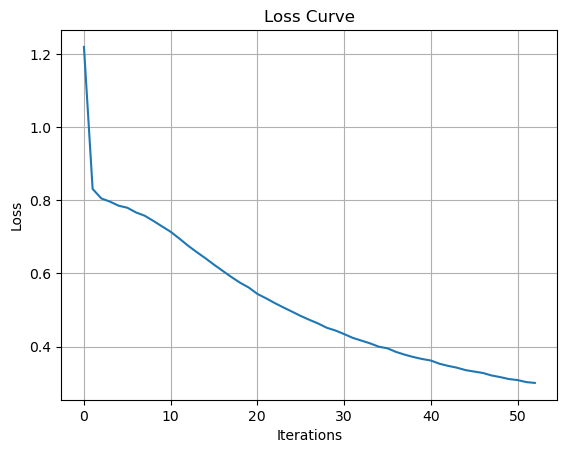

R2 for mlp_regressor_pipeline: 0.36473235730109166
MSE for mlp_regressor_pipeline: 1.6748727850300829
MAE for mlp_regressor_pipeline: 1.0449251071600882
Combination: (64, (128, 64, 32), 0.001, 'tanh') , R2: {'mlp_regressor_pipeline': 0.36473235730109166} , MSE: {'mlp_regressor_pipeline': 1.6748727850300829} , MAE: {'mlp_regressor_pipeline': 1.0449251071600882}


mlp_regressor_pipeline trained


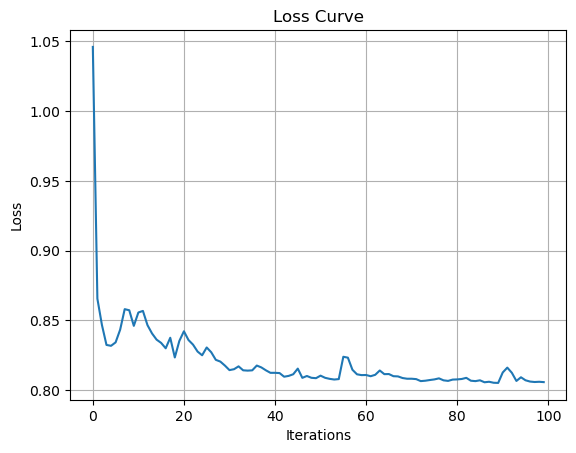

R2 for mlp_regressor_pipeline: 0.39070666100638696
MSE for mlp_regressor_pipeline: 1.6063919566956164
MAE for mlp_regressor_pipeline: 0.9860222419319647
Combination: (64, (128, 64, 32), 0.01, 'relu') , R2: {'mlp_regressor_pipeline': 0.39070666100638696} , MSE: {'mlp_regressor_pipeline': 1.6063919566956164} , MAE: {'mlp_regressor_pipeline': 0.9860222419319647}


mlp_regressor_pipeline trained


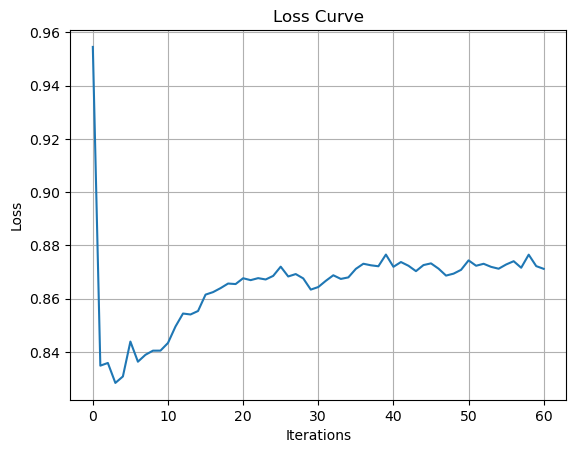

R2 for mlp_regressor_pipeline: 0.38893301082417275
MSE for mlp_regressor_pipeline: 1.6110681564902944
MAE for mlp_regressor_pipeline: 0.9907498060456693
Combination: (64, (128, 64, 32), 0.01, 'tanh') , R2: {'mlp_regressor_pipeline': 0.38893301082417275} , MSE: {'mlp_regressor_pipeline': 1.6110681564902944} , MAE: {'mlp_regressor_pipeline': 0.9907498060456693}




In [25]:
keys, values = zip(*grid_params.items())
model_ranking_reg = {}
models_reg = {}
# Iterate over every combination of parameters
for combination in itertools.product(*values):
    # Create a dictionary for the current combination of parameters
    params = dict(zip(keys, combination))
    # You can now use the 'params' dictionary for training or evaluation
    nn_models = model_utils.init_nn(params,type='regression')
    model_utils.train_models(nn_models, x_train_reg, y_train_reg)
    preds = model_utils.predict(nn_models, x_test_reg)
    r2,mse,mae = model_utils.eval_regression(y_true=y_test_reg,preds=preds)
    model_ranking_reg[combination] = mae
    models_reg[combination] = nn_models
    print('Combination:',combination,', R2:', r2,', MSE:',mse,', MAE:',mae)
    print('\n')

In [26]:
# Sort the models by their ROC AUC score, from highest to lowest, each item in model_ranking is a dictionary
sorted_models_reg = sorted(model_ranking_reg.items(), key=lambda x: x[1]["mlp_regressor_pipeline"], reverse=False)
sorted_models_reg[:10]

[((64, (128, 64, 32), 0.01, 'relu'),
  {'mlp_regressor_pipeline': 0.9860222419319647}),
 ((64, (128, 64, 32), 0.01, 'tanh'),
  {'mlp_regressor_pipeline': 0.9907498060456693}),
 ((64, (64, 32), 0.01, 'tanh'),
  {'mlp_regressor_pipeline': 1.0162721813726485}),
 ((64, (64, 32), 0.01, 'relu'),
  {'mlp_regressor_pipeline': 1.0178588589258981}),
 ((64, (128, 64), 0.01, 'relu'),
  {'mlp_regressor_pipeline': 1.0215575579129397}),
 ((64, (128, 64), 0.01, 'tanh'),
  {'mlp_regressor_pipeline': 1.0354015968855306}),
 ((64, (128, 64, 32), 0.001, 'tanh'),
  {'mlp_regressor_pipeline': 1.0449251071600882}),
 ((64, (128, 64, 32), 0.001, 'relu'),
  {'mlp_regressor_pipeline': 1.045454998759125}),
 ((64, (64, 32), 0.001, 'tanh'),
  {'mlp_regressor_pipeline': 1.0496781486150344}),
 ((64, (64, 32), 0.0001, 'tanh'),
  {'mlp_regressor_pipeline': 1.050649405472454})]

In [27]:
# Save the best model using pickle
best_params_reg = sorted_models_reg[0][0]
best_model_reg = models_reg[best_params_reg]
with open('best_model_reg.pkl', 'wb') as f:
    pickle.dump(best_model_reg, f)